In [1]:
import pandas as pd
import numpy as np
import math
import itertools
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from pathlib import Path
from sklearn.preprocessing import scale, normalize, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn import svm
import lightgbm as lgb
from copy import deepcopy
import pydotplus
from IPython.display import Image
from category_encoders import OrdinalEncoder, CountEncoder, TargetEncoder
pd.options.mode.chained_assignment = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def find_null(df_):
    '''
    Returns all indices with null values for every column in a DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
    Returns
        nulls_ : Dictionary
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    nulls_ = {}
    for col in df_.columns:
        null_indices = total_df[col].loc[total_df[col].isnull()].index.values.tolist()
        nulls_[col] = null_indices
        
    return nulls_

In [3]:
def drop_null_cols(df_, col_to_check=[], threshold=0):
    '''
    Drop columns with null values above a threshold if specified.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}.
            Default is 0.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_check, str):
        col_to_check = [col_to_check]
    elif not isinstance(col_to_check, list):
        col_to_check = list(col_to_check)
    if not col_to_check:
        col_to_check = df_.columns
    rows_size = df_.shape[0]
    # Drops columns that have null values above the specified threshold
    if isinstance(threshold, int):
        new_df = df_[col_to_check].dropna(axis=1, thresh=rows_size-threshold)
    elif threshold <= 1.0 and threshold >= 0.0:
        new_df = df_[col_to_check].dropna(axis=1, thresh=rows_size-int(rows_size*threshold))
    else:
        raise TypeError(f'{threshold} of wrong type or out of range')
    df_.drop(columns=np.setdiff1d(col_to_check, new_df.columns), inplace=True)
    return df_

In [4]:
def drop_null_rows(df_, col_to_check=[], threshold=0):
    '''
    Drop rows with null values above a threshold if specified.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}
            of every row. Default is 0.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_check, str):
        col_to_check = [col_to_check]
    elif not isinstance(col_to_check, list):
        col_to_check = list(col_to_check)
    if not col_to_check:
        col_to_check = df_.columns
    cols_size = len(col_to_check)
    # Drop rows that have null values above the specified threshold
    if isinstance(threshold, int):
        df_.dropna(axis=0, thresh=cols_size-threshold,
                   subset=col_to_check, inplace=True)
    elif threshold <= 1.0 and threshold >= 0.0:
        df_.dropna(axis=0, thresh=cols_size-int(cols_size*threshold),
                   subset=col_to_check, inplace=True)
    else:
        raise TypeError(f'{threshold} of wrong type or out of range')
    return df_
    

In [5]:
def fill_null(col_, const_=None, col_replace_=None, lin_predict=None, oper_="", col_oper_=None):
    '''
    Fill null in {col_replace_} with {constant} or a transformation of {col_math_}.
    
    Parameters:
        col_ : list or array-like
            Column with null values to replace.
        const_ : int or float, optional
            Value to replace null in {col_} with. Default is 0.
        col_replace_ : list or array-like or Series, optional
            Values to replace null values in {col_}, must be of equal dimension.
            Default is 0.
        lin_predict_ : DataFrame, optional
            Replaces null values in {col_} with predictions from a
            linear regression model trained on the non-null values.
            Will drop rows with null values not in {col_} before training.
        oper_ : str, optional
            Replaces null values in {col_} with the operation specified
            for non-null in {col_oper_}.
            Mean, Median, Mode, Std, Min, Max, Range, 25, 75
        col_oper_ : Series, optional
            Column that will be operated upon by one of the above to fill
            the null values in {col_}. Default is {col_}.
    Returns:
        col_ : Series
    '''
    if not isinstance(col_, pd.Series):
        col_ = pd.Series(col_)
    # If no other parameters are passed, nulls will be set to 0.
    if (const_ is None and col_replace_ is None and lin_predict is None and
        oper_=="" and col_math_ is None):
        col_.fillna(0, inplace=True)
        return col_
    # Nulls will be set to const_.
    if const_:
        col_.fillna(const_, inplace=True)
        return col_
    # Nulls will be set to a list-like structure of equal length.
    if col_replace_ is not None:
        try:
            col_.loc[col_.isnull()] = list(col_replace_)
            return col_
        except ValueError:
            raise ValueError(f"Can't set length of {len(col_replace_)} to index of length {len(col_.loc[col_.isnull()])}")
    # Nulls will be predicted using linear regression.
    if lin_predict is not None:
        notnull_df_ = lin_predict.dropna()
        linreg = LinearRegression()
        train_x = notnull_df_.drop(columns=[col_.name])
        train_y = notnull_df_[col_.name]
        linreg.fit(train_x, train_y)
        test_y = linreg.predict(lin_predict.drop(columns=[col_.name]))
        col_.fillna(pd.Series(test_y), inplace=True)
        return col_
    # Nulls will be set to the mean of col_math_
    oper_ = oper_.lower()
    if col_oper_ is None:
        col_oper_ = col_
    elif not isinstance(col_oper_, pd.Series):
        col_oper_ = pd.Series(col_oper_)
    if oper_=="mean":
        col_.fillna(col_oper_.mean(), inplace=True)
    elif oper_=="median":
        col_.fillna(col_oper_.median(), inplace=True)
    elif oper_=="mode":
        col_.fillna(stats.mode(col_oper_)[0][0], inplace=True)
    elif oper_=="std":
        col_.fillna(col_oper_.std(), inplace=True)
    elif oper_=="min":
        col_.fillna(col_oper_.min(), inplace=True)
    elif oper_=="max":
        col_.fillna(col_oper_.max(), inplace=True)
    elif oper_=="range":
        col_.fillna(col_oper_.max()-col_math_.min(), inplace=True)
    elif oper_=="25":
        col_.fillna(col_oper_.describe()["25%"], inplace=True)
    elif oper_=="75":
        col_.fillna(col_oper_.describe()["75%"], inplace=True)
    return col_
    

In [6]:
def category_encode(df_, col_to_encode=[], encoder_type=None, target_col=[]):
    '''
    Transform categorical variables into integers through encoding.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_encode : str, list or array-like, optional
            Column(s) to encode. Default is every column.
        encoder_type : str, optional
            Method of encoding {col_to_encode}.
            OneHot, Ordinal, Count, or Target.
        target_col : str
            Target column, only used with TargetEncoder.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_encode, str):
        col_to_encode = [col_to_encode]
    elif not isinstance(col_to_encode, list):
        col_to_encode = list(col_to_encode)
    if not col_to_encode:
        col_to_encode = df_.columns
    encoder_type = encoder_type.lower()
    if encoder_type=="onehot":
        encoded = pd.get_dummies(df_[col_to_encode])
        df_.drop(columns=col_to_encode, inplace=True)
        df_ = df_.join(encoded)
        return df_
    if not encoder_type or encoder_type=="ordinal":
        encoder = OrdinalEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode])
    elif encoder_type=="count":
        encoder = CountEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode])
    elif encoder_type=="target":
        encoder = TargetEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode], df_[target_col])
    df_[col_to_encode] = encoded
    return df_
    

In [7]:
def corr_matrix(df_, exclude_label=None, method="pearson"):
    '''
    Displays and returns a correlation matrix for the DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        exclude_label : str, optional
            Exclude column from the correlation.
    Returns:
        df_corr : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(8, 6))
    if exclude_label:
        df_ = df_.drop(columns=[exclude_label])
    df_corr = df_.corr(method=method)
    mask = np.zeros_like(np.array(df_corr))
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df_corr, mask=mask, annot=True)
    
    return df_corr

In [8]:
def box_plot(df_, exclude_label=None):
    '''
    Displays a boxplot for the DataFrame along with relevant information.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        exclude_label : str, optional
            Exclude column from the boxplot.
    Returns:
        columns_data : Dict
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(9, 6))
    if exclude_label:
        df_ = df_.drop(columns=[exclude_label])
    df_stand_ = pd.DataFrame(scale(df_), columns=df_.columns)
    ax = sns.boxplot(data=df_stand_, orient="v", fliersize=2)
    columns_data = {}
    for col in df_stand_.columns:
        col_data = {} 
        col_data["Max"] = df_stand_[col].max()
        col_data["75%"] = df_stand_[col].describe()["75%"]
        col_data["50%"] = df_stand_[col].median()
        col_data["25%"] = df_stand_[col].describe()["25%"]
        col_data["Min"] = df_stand_[col].min()
        col_data["Top_IQR"] = df_stand_[col].std()*1.5 + col_data["75%"]
        col_data["Bottom_IQR"] = col_data["25%"] - df_stand_[col].std()*1.5
        outliers_top = df_stand_[df_stand_[col] > col_data["Top_IQR"]][col]
        outliers_bottom = df_stand_[df_stand_[col] < col_data["Bottom_IQR"]][col]
        col_data["Top_Outliers"] = outliers_top.index.values
        col_data["Bottom_Outliers"] = outliers_bottom.index.values
        if (len(outliers_top) == 0):
            col_data["Top_IQR"] = col_data["Max"]
        if (len(outliers_bottom == 0)):
            col_data["Bottom_IQR"] = col_data["Min"]
        columns_data[col] = col_data
        
    return columns_data

In [9]:
def scatter_matrix(df_, cols_=None, hue_=None):
    '''
    Displays a scatter matrix of specified variables.
    Defaults to a scatter matrix of all columns.
            
    Parameters:
        df_ : DataFrame or 2-dimensional array
        cols_ : list or array-like: optional
            Column variables for scatter matrix. Default is all columns.
    Returns:
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if not cols_:
        cols_ = df_.columns
    g = sns.pairplot(data=df_, vars=cols_, hue=hue_)
    for i, j in zip(*np.triu_indices_from(g.axes, 1)):
        g.axes[i, j].set_visible(False)

In [145]:
def handle_outliers(df_, boxplot_dict=None, direction=None, clip=False, clip_value=None, z_thresh=3):
    '''
    Handles outliers in a set.
    Defaults to dropping obervations outside of 3 standard deviations.
            
    Parameters:
        df_ : DataFrame or 2-dimensional array
        boxplot_dict : Dict, optional
            Output of box_plot function. Drops observations outside whiskers range. 
        direction : str, optional
            Indicates which direction to drop outliers from. Top or Bottom.
            Defaults to Both.
        clip : bool, optional
            Clips the outlier. If boxplot_dict was passed, limits outlier to whiskers.
            Else limits it to 3 standard deviations. Default is False.
        z_thresh : int, float, optional
            The threshold of standard deviations beyond which outliers will be dropped.
            Defaults to 3.
    Returns:
        df_no_outliers_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if not direction:
        direction = ""
    # If boxplot_dict is passed, use data from that to remove outliers
    # If clip is True, outliers will be set to the whiskers range, else
    # the entire row will be dropped 
    if boxplot_dict:
        outliers_ = []
        if direction.lower() == 'top':
            for col_, data_ in boxplot_dict.items():
                if clip:
                    df_.loc[data_["Top_Outliers"],[col_]] = data_["Top_IQR"]
                else:
                    outliers_.extend([ind_ for ind_ in data_["Top_Outliers"]])
        elif direction.lower() == 'bottom':
            for col_, data_ in boxplot_dict.items():
                if clip:
                    df_.loc[data_["Bottom_Outliers"],[col_]] = data_["Bottom_IQR"]
                else:
                    outliers_.extend([ind_ for ind_ in data_["Bottom_Outliers"]])
        else:
            for col_, data_ in boxplot_dict.items():
                if clip:
                    df_.loc[data_["Top_Outliers"],[col_]] = data_["Top_IQR"]
                    df_.loc[data_["Bottom_Outliers"],[col_]] = data_["Bottom_IQR"]
                else:
                    outliers_.extend([ind_ for ind_ in data_["Top_Outliers"]])
                    outliers_.extend([ind_ for ind_ in data_["Bottom_Outliers"]])
        if not clip:
            df_.drop(set(outliers_), inplace=True)
    else:
        # Iterates through every column and clips any outliers
        if clip:
            if clip_value:
                for col_ in df_.columns:
                    if direction.lower() == 'top':
                        df_.loc[df_[col_]>clip_value,[col_]] = clip_value
                    elif direction.lower() == 'bottom':
                        df_.loc[df_[col_]<clip_value,[col_]] = clip_value
                    else:
                        raise ValueError("Direction cant be BOTH if clip_value is passed")
            else:
                for col_ in df_.columns:
                    outlier_thresh = df_[col_].mean() + z_thresh * df_[col_].std()
                    if direction.lower() == 'top':
                        df_.loc[df_[col_]>outlier_thresh,[col_]] = outlier_thresh
                    elif direction.lower() == 'bottom':
                        df_.loc[df_[col_]<-1*outlier_thresh,[col_]] = -1*outlier_thresh
                    else:
                        df_.loc[df_[col_]>outlier_thresh,[col_]] = outlier_thresh
                        df_.loc[df_[col_]<-1*outlier_thresh,[col_]] = -1*outlier_thresh
        else: # Drops any rows with any column values with outliers
            if direction.lower() == 'top':
                df_ = df_[(stats.zscore(df_) < z_thresh).all(axis=1)]
            elif direction.lower() == 'bottom':
                df_ = df_[(stats.zscore(df_) > -1*z_thresh).all(axis=1)]
            else:
                df_ = df_[(np.abs(stats.zscore(df_)) < z_thresh).all(axis=1)]
    return df_

In [11]:
def transform(df_, cols_=None, transform_="standardize"):
    '''
    Transforms a DataFrame's specified columns.
    Defaults to standardizing all columns.
            
    Parameters:
        df_ : DataFrame or 2-dimensional array
        cols_ : list or array-like, optional
            Columns to transform. Default is all columns.
        transform_ : str, or list or array-like, optional
            Transformation to apply to columns. Default is standardize.
            Standardize, normalize, log, cuberoot, squareroot, cube, or square.
    Returns:
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if not cols_:
        cols_ = df_.columns
    if isinstance(transform_, str):
        transform_ = list([transform_])*df_.shape[1]
    for counter_, col_ in enumerate(cols_):
        if transform_[counter_].lower()=="standardize":
            df_[col_] = scale(df_[col_])
        elif transform_[counter_].lower()=="normalize":
            df_[col_] = normalize(df_[[col_]], axis=0)
        elif transform_[counter_].lower()=="log":
            df_[col_] = np.log1p(df_[col_])
        elif transform_[counter_].lower()=="cuberoot":
            df_[col_] = np.cbrt(df_[col_])
        elif transform_[counter_].lower()=="squareroot":
            df_[col_] = np.sqrt(df_[col_])
        elif transform_[counter_].lower()=="cube":
            df_[col_] = np.power(df_[col_], 3)
        elif transform_[counter_].lower()=="square":
            df_[col_] = np.square(df_[col_])
    
    return df_
        

In [43]:
def bucket(df_, col_, bins_):
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if not isinstance(bins_, list):
        bins_ = list([bins_])
    return pd.cut(df_[col_], bins_, labels=["Extreme Value", "Value", "Popular Premium", "Premium", "Super Premium", "Ultra Premium", "Luxury", "Super Luxury", "Icon"], retbins=True)

In [214]:
def scatter_dist(df_, cols_=None, label_=None):
    '''
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_ : str, list
            Column to place on the x-axis.
        label_ : str, optional
            Column to place on the y-axis. Default is counting the instances
            of {col_}.
        type_ : int, optional
            Type of data plotting (x by y). Options are 0, (categorical vs categorical),
            1 (categorical vs numeric) or 2 (numeric vs numeric).
        hue_ : str, optional
            Variable for separating data by color.
    Returns:
        
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if not isinstance(cols_, list):
        cols_ = list([cols_])
    if not cols_:
        cols_ = df_.columns.values
    num_of_plots = len(cols_)
    fig, axes = plt.subplots(nrows=(math.ceil(num_of_plots/2) if num_of_plots>2 else 1),
                             ncols=(2 if num_of_plots>1 else 1), figsize=(14, 10))
    if num_of_plots==1:
        axes = np.array(axes)
    axes = axes.ravel()
    if num_of_plots>1 and num_of_plots%2==1:
        axes[-1].set_visible(False)
    palette = itertools.cycle(sns.color_palette())
    for axis_num_, col_ in enumerate(cols_):
        col_mean = round(df_[col_].mean(), 2)
        col_std = round(df_[col_].std(), 2)
        col_max = round(df_[col_].max(), 2)
        col_min = round(df_[col_].min(), 2)
        column_ = df_[[col_]]
        bw_ = np.power(len(column_), -1./(5))
        my_plt = sns.distplot(column_, color=next(palette), ax=axes[axis_num_])
        legend_ = my_plt.legend([f'Mean: {col_mean} \nStd: {col_std} \nRange: [{col_min},{col_max}]'], loc='best')

In [217]:
def single_dist(df_, vars_=None, type_=0, hue_=None):
    '''
    Displays a distribution of {vars} from {df_}.
    Depending on the type of {vars}, different distributions will be plotted.
    Countplot for 1 variable.
    Heatmap for 2 categorical variables.
    Swarmplot for 1 categorical and 1 numeric variable.
    Scatterplot for 2 numeric variables.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        vars_ : str, list
            Variable(s) to plot.
        type_ : int, optional
            Type of data plotting. Options are 0, (categorical vs categorical),
            1 (categorical vs numeric) or 2 (numeric vs numeric). Default is 0.
        hue_ : str, optional
            Variable for separating data by color. Not used if type=1.
    Returns:
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(vars_,str):
        vars_ = list([vars_])
    fig, ax = plt.subplots(figsize=(24, 10))
    if len(vars_)==1:
        if hue:
            ax = sns.countplot(x=vars_[0], hue=hue_, data=df_)
        else:
            ax = sns.countplot(x=vars_[0], data=df_)
    else:
        if type_==0:
            sns.set(font_scale=1.6)
            #plt.xlabel(vars_[0], fontsize=30)
            #plt.ylabel(vars_[1], fontsize=30)
            df_ = pd.DataFrame(df_[vars_].groupby(vars_).size())
            df_ = df_.reset_index().pivot(columns=vars_[0], index=vars_[1], values=df_.columns[-1])
            df_.rename(columns={"0": "Values"})
            df_.fillna(0, inplace=True)
            #df2 = df2.astype(int)
            ax = sns.heatmap(df_, annot=True, fmt='g')
        elif type_==1:
            if hue_:
                ax = sns.swarmplot(x=vars_[0], y=vars_[1], hue=hue_, dodge=True, data=df_)
            else:
                ax = sns.swarmplot(x=vars_[0], y=vars_[1], dodge=True, data=df_)
                #ax.legend(['Mea'], loc='center right')
        elif type_==2:
            if hue_:
                sns.scatterplot(x=vars_[0], y=vars_[1], data=df_, hue=hue_)
            else:
                sns.scatterplot(x=vars_[0], y=vars_[1], data=df_)

In [231]:
wine_df = pd.read_csv('../WineData.csv')
wine_df = wine_df.drop("Link", 1)
wine_df[11445:11462]

,ID,Wine,Region,Subregion,Appellation,Vineyard,Grape,Score,Popularity,Price,Country
11445,11445,"Domaine Fournillon Les Fourneaux, Chablis Prem...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Fourneaux,Chardonnay,NaN,"209,333rd",26,France
11446,11446,"Chateau de Fleys Les Fourneaux, Chablis Premie...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Fourneaux,Chardonnay,89.0,"230,079th",17,France
11447,11447,"Verget Les Fourneaux, Chablis Premier Cru, France",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Fourneaux,Chardonnay,88.0,"230,079th",54,France
11448,11448,"Domaine Daniel-Etienne Defaix Les Lys, Chablis...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,89.0,"8,357th",41,France
11449,11449,"Albert Bichot Domaine Long-Depaquit Les Lys, C...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,89.0,"23,581st",32,France
11450,11450,"William Fevre Les Lys, Chablis Premier Cru, Fr...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,91.0,"34,869th",39,France
11451,11451,"Domaine Vincent Dampt Les Lys, Chablis Premier...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,89.0,"35,275th",26,France
11452,11452,"La Chablisienne Les Lys, Chablis Premier Cru, ...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,90.0,"62,673rd",25,France
11453,11453,"Domaine Daniel Dampt et Fils Les Lys, Chablis ...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,90.0,"85,555th",32,France
11454,11454,"Domaine Buisson-Charles Les Lys, Chablis Premi...",Burgundy,Chablis,Chablis Premier Cru,Chablis Les Lys,Chardonnay,NaN,"87,999th",43,France


KeyboardInterrupt: 

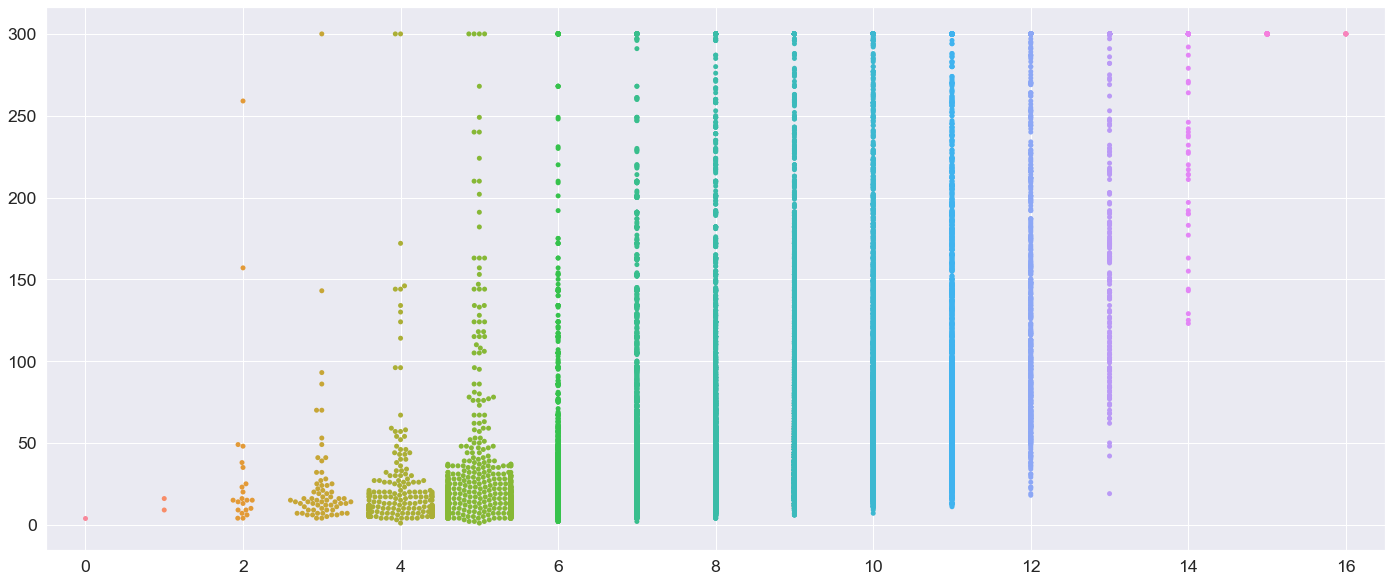

In [220]:
single_dist(wine_df, ["Score", "Price"], 1)

In [209]:
wine_df["PriceBucket"] = bucket(wine_df, "Price", [0, 5, 10, 15, 20, 30, 50, 100, 200, 100000])[0]
#print(bucket(wine_df, "Price", [0, 5, 10, 15, 20, 30, 50, 100, 200, 100000])[0])
french_wines_ = wine_df.loc[wine_df["Country"]=="France"]
bordeaux_wines_ = french_wines_.loc[french_wines_["Region"]=="Bordeaux"]
for grape_ in bordeaux_wines_.Grape.unique():
    if bordeaux_wines_.loc[bordeaux_wines_["Grape"]==grape_]["Subregion"].nunique() > 1:
        print(grape_)
        print(bordeaux_wines_.loc[bordeaux_wines_["Grape"]==grape_].shape[0])

Bordeaux Blend Red
1515
Malbec - Merlot
4
Sauvignon Blanc - Semillon
52
Cabernet Sauvignon
5
Cabernet Sauvignon - Merlot
53
Rare White Blend
11
Merlot
27
Cabernet Franc - Merlot
47
Semillon
12
Bordeaux Blend White
188
Sauvignon Blanc
5


In [148]:
wine_df["Price"] = handle_outliers(wine_df["Price"], direction="Top", clip=True, clip_value=300)

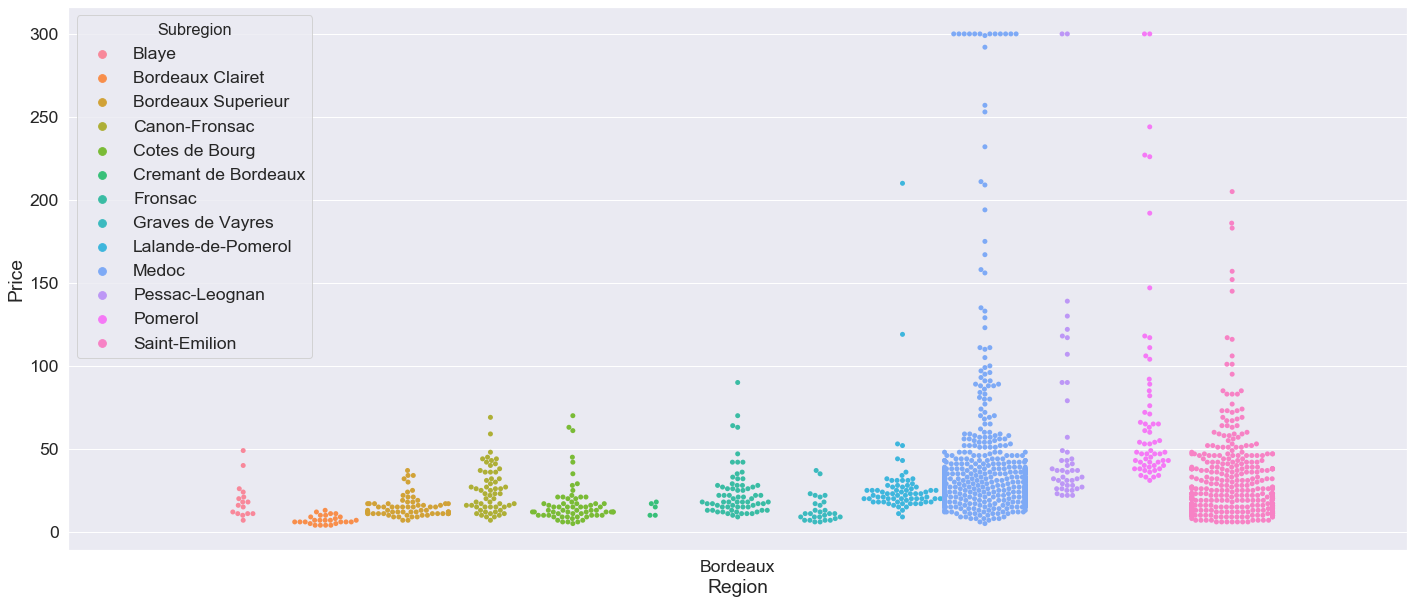

In [211]:
#single_dist(wine_df.loc[wine_df["Country"]=="France"], vars_=["Region", "PriceBucket"], type_=[0,0])
#french_wines_ = wine_df.loc[wine_df["Country"]=="France"]
single_dist(bordeaux_wines_.loc[bordeaux_wines_["Grape"].isin(["Bordeaux Blend Red"])], vars_=["Region", "Price"], type_=1, hue_="Subregion")

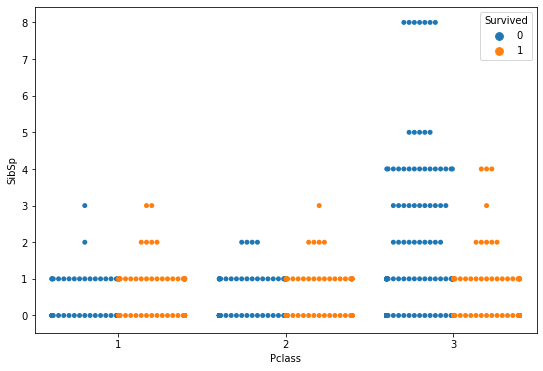

In [1381]:
single_dist(train_df, vars_=["Pclass", "SibSp"], type_=[0,1], hue_="Survived")

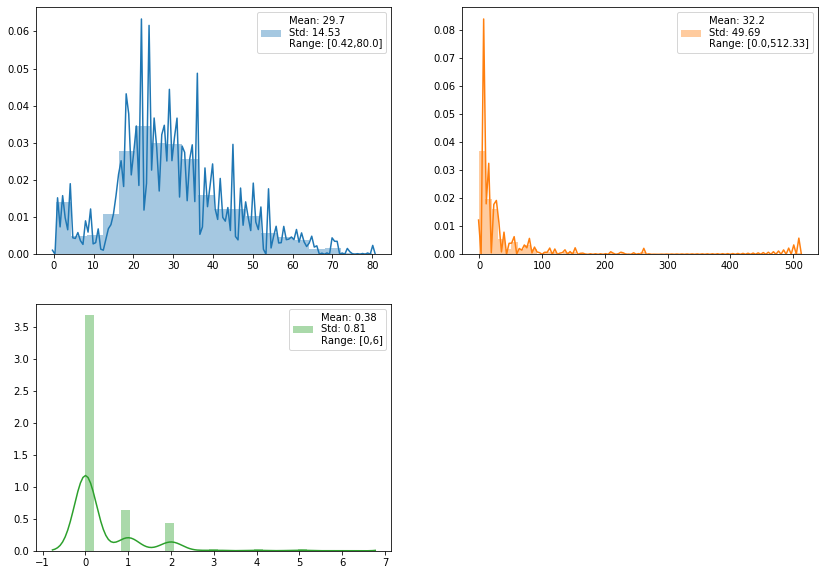

In [1085]:
multiple_dist(train_df, ["Age", "Fare", "Parch"], "Survived")

In [1134]:
train_df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
train_df = drop_null_cols(train_df, threshold=0.2)
train_df = drop_null_rows(train_df, ["Embarked"])
train_df = category_encode(train_df, ["Sex", "Embarked"], "ordinal")
train_df["Age"] = fill_null(train_df["Age"], lin_predict=train_df[["Pclass", "Age", "Sex", "SibSp",
                                                                   "Parch", "Fare", "Embarked"]])
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,1
1,1,1,2,38.000000,1,0,71.2833,2
2,1,3,2,26.000000,0,0,7.9250,1
3,1,1,2,35.000000,1,0,53.1000,1
4,0,3,1,35.000000,0,0,8.0500,1
...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,1
887,1,1,2,19.000000,0,0,30.0000,1
888,0,3,2,27.866658,1,2,23.4500,1
889,1,1,1,26.000000,0,0,30.0000,2


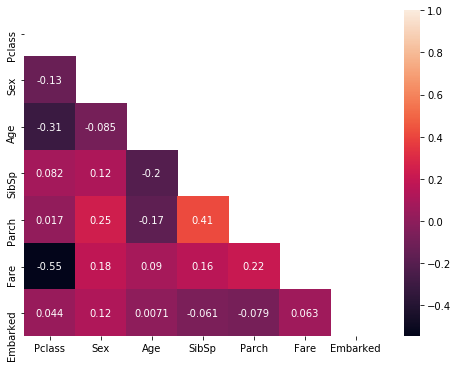

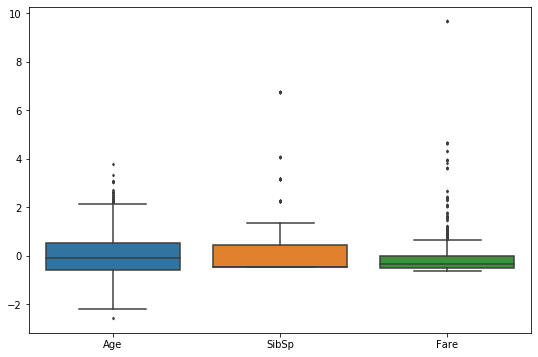

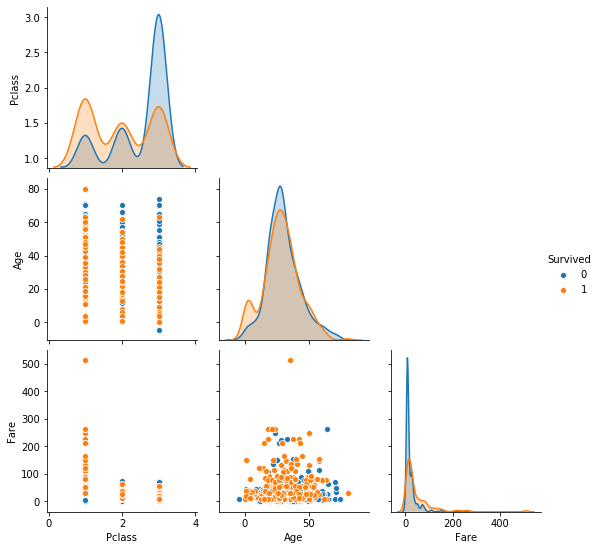

In [921]:
corr_ = corr_matrix(train_df, exclude_label="Survived")
outliers_ = box_plot(train_df[["Age", "SibSp", "Fare"]])
scatter_matrix(train_df, ["Pclass", "Age", "Fare"], "Survived")

In [ ]:
labels_ = total_df["Survived"]
features_ = total_df.drop(columns=["Survived"])
features_ = handle_outliers(features_, direction="Top", clip=False, z_thresh=3)
features_ = transform(features_, transform_=["","","standardize", "","","squareroot",""])
features_

In [ ]:
total_df = features_.merge(labels_, left_index=True, right_index=True)
total_df.reset_index(drop=True, inplace=True)
total_df

In [ ]:
distributions(total_df, ["Age", "Fare", "SibSp", "Pclass", "Parch"])

In [ ]:
train_df, val_df = train_test_split(total_df)
train_df_feat = train_df.drop(columns=["Survived"])
train_df_label = train_df[["Survived"]]
val_df_feat = val_df.drop(columns=["Survived"])
val_df_label = val_df[["Survived"]]

In [ ]:
total_df

In [ ]:
#test_df = pd.read_csv("../test.csv")
#test_df = category_encode(test_df, ["Sex", "Embarked"], "ordinal")
#test_df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
model = lgb.train(param, training, num_round, valid_sets=[validation], early_stopping_rounds=10, verbose_eval=False)
pred = model.predict(scale(val_df_feat))
score = roc_auc_score(val_df_label, pred)
print(f"Test AUC score: {score}")

In [ ]:
pipeline = make_pipeline(RandomForestRegressor(n_estimators=100))
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
clf = GridSearchCV(pipeline, hyperparameters, cv=5)
 
clf.fit(scale(train_df_feat), np.array(train_df_label).ravel())
pred = clf.predict(scale(val_df_feat))
print(r2_score(val_df_label, pred))
print(np.sqrt(mean_squared_error(val_df_label, pred)))

In [ ]:
clf = svm.SVC()
clf.fit(np.array(scale(train_df_feat)), np.array(train_df_label).ravel())
preds = clf.predict(np.array(scale(val_df_feat)))
score = roc_auc_score(np.array(val_df_label).ravel(), preds)
score

In [ ]:
scores = []
for neighbor_ in range(50,80):
    model = KNeighborsClassifier(n_neighbors=neighbor_, weights="distance")
    model.fit(np.array(scale(train_df_feat)), np.array(train_df_label).ravel())
    preds = model.predict(np.array(scale(val_df_feat)))
    score = roc_auc_score(np.array(val_df_label).ravel(), preds)
    scores.append([neighbor_, score])
scores = pd.DataFrame(scores, columns=["Neighbors", "Score"])
scores